In [41]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
        
class Sudoku4x4RandomPatternDataset(torch.utils.data.IterableDataset):
    def __init__(self):
        self.size = 4
        self.difficulty = 0.4
        
    def __iter__(self):
        return self

    def __next__(self):
        n = self.size
        target = torch.stack([torch.arange(n**2).add(1).roll(i).roll(j*n) for i in range(n) for j in range(n)])
        for i in range(n):
            for r in range(0,n**2,n):
                target[r:r+n,:] = target[torch.randperm(n)+r,:]
            for c in range(0,n**2,n):
                target[:,c:c+n] = target[:,torch.randperm(n)+c]
    
        challenge = target.clone()
        challenge[torch.rand_like(challenge.float()) < self.difficulty] = 0
        pchallenge = torch.zeros_like(challenge).repeat(4,4)[:-1,:-1] #F.interpolate(buffer[None,None].float(), scale_factor=self.scale, mode="nearest")[0,0].long()
        ptarget = torch.zeros_like(target).repeat(4,4)[:-1,:-1] #F.interpolate(target[None,None].float(), scale_factor=self.scale, mode="nearest")[0,0].long()
        
        patterns = F.pad(torch.rand(16,3,3).gt(0.5) * torch.randint(1,11,(16,1,1)),(0,0,0,0,1,0))
 
        for row in range(self.size**2):
            for col in range(self.size**2):
                pchallenge[row*4:row*4+3,col*4:col*4+3] = patterns[challenge[row,col].item()]
                ptarget[row*4:row*4+3,col*4:col*4+3] = patterns[target[row,col].item()]

        return pchallenge[None], ptarget[None] 

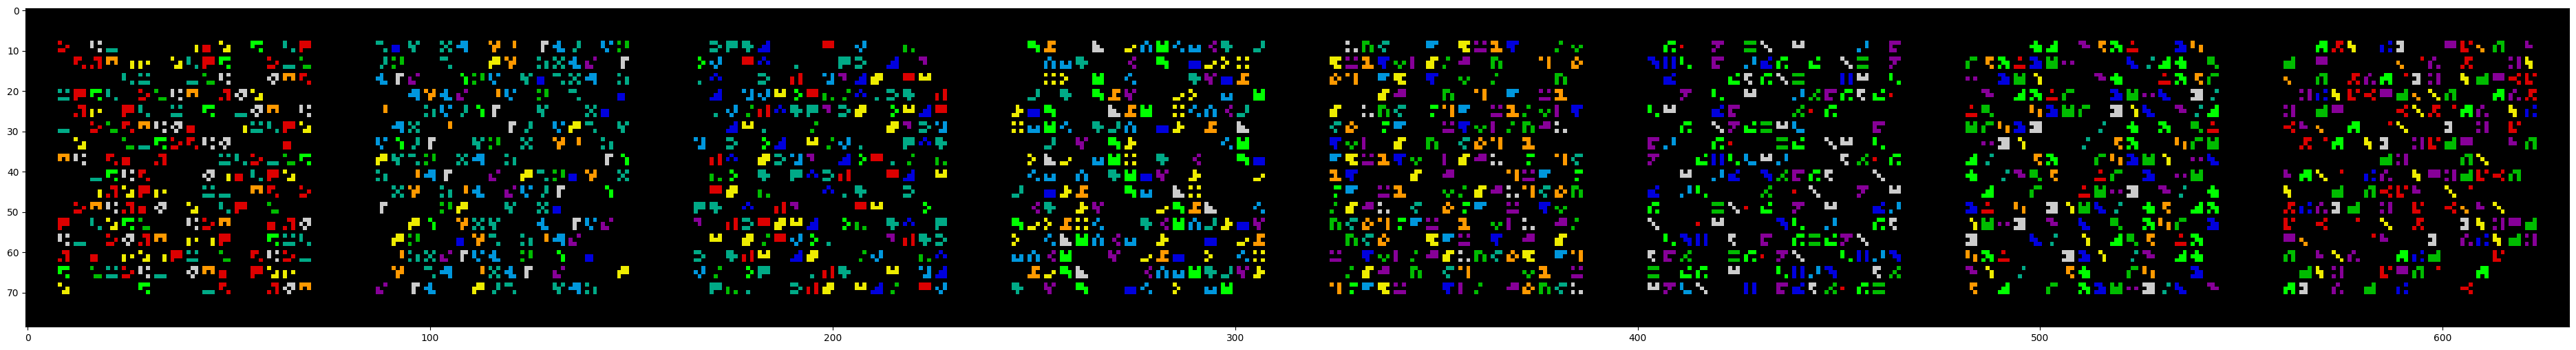

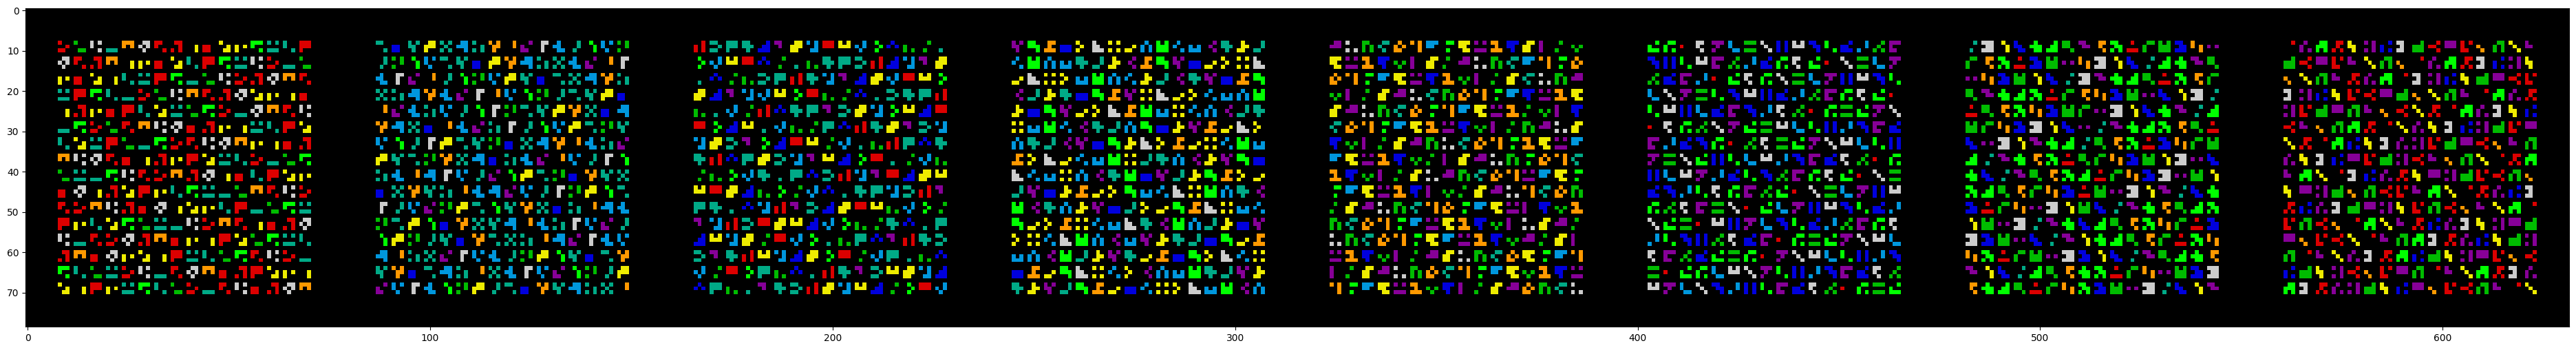

In [42]:
dataset = Sudoku4x4RandomPatternDataset()
loader = torch.utils.data.DataLoader(dataset, batch_size=8)
batch, target = next(iter(loader))

batch = torch.cat([F.pad(b, (8,8,8,8)) for b in batch.unbind()], -1)
plt.figure(figsize=(48,6))
plt.imshow(batch.permute(1,2,0).mul(24).numpy(), cmap="nipy_spectral")
plt.show()

target = torch.cat([F.pad(t, (8,8,8,8)) for t in target.unbind()], -1)
plt.figure(figsize=(48,6))
plt.imshow(target.permute(1,2,0).mul(24).numpy(), cmap="nipy_spectral")
plt.show()
